#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

#### Load dataset

In [2]:
df = pd.read_csv("Mean Store Data.csv", index_col="Date")
df.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [4]:
df.describe()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,143.00,143.00,143.00,143.00,143.00,143.00
mean,1555264.40,0.07,68.31,3.22,216.00,7.61
std,155980.77,0.26,14.25,0.43,4.35,0.38
min,1316899.31,0.00,35.40,2.51,210.34,6.57
25%,1458104.69,0.00,58.27,2.76,211.55,7.35
50%,1534849.64,0.00,69.64,3.29,215.46,7.79
75%,1614892.03,0.00,80.48,3.59,220.53,7.84
max,2387950.20,1.00,91.65,3.91,223.44,8.11


### Data Visualization

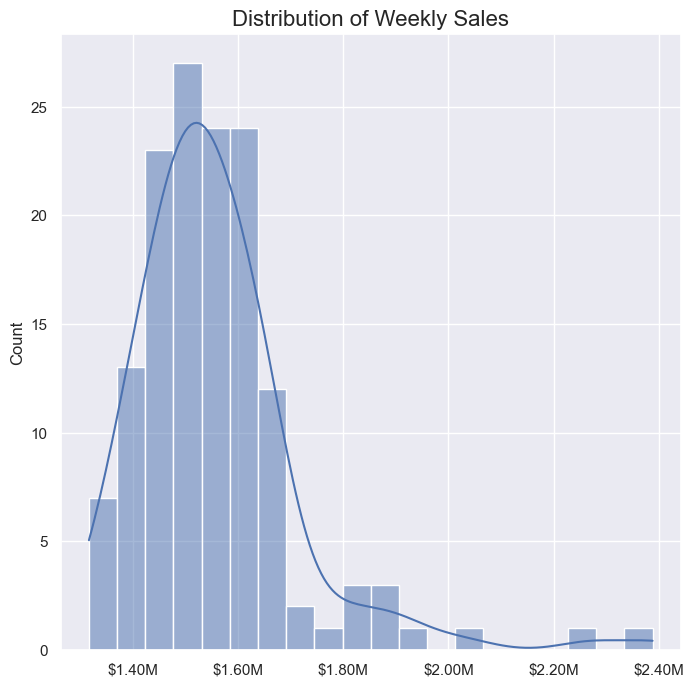

In [5]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 8))
g = sns.histplot(df["Weekly_Sales"], bins=20, kde=True)

xticks = plt.xticks()[0][1:-1]
tick_labels = [f"${tick/1e6:.2f}M" for tick in xticks]
g.set_xticks(xticks)
g.set_xticklabels(tick_labels)

plt.xlabel("")
plt.title("Distribution of Weekly Sales", fontsize=16);

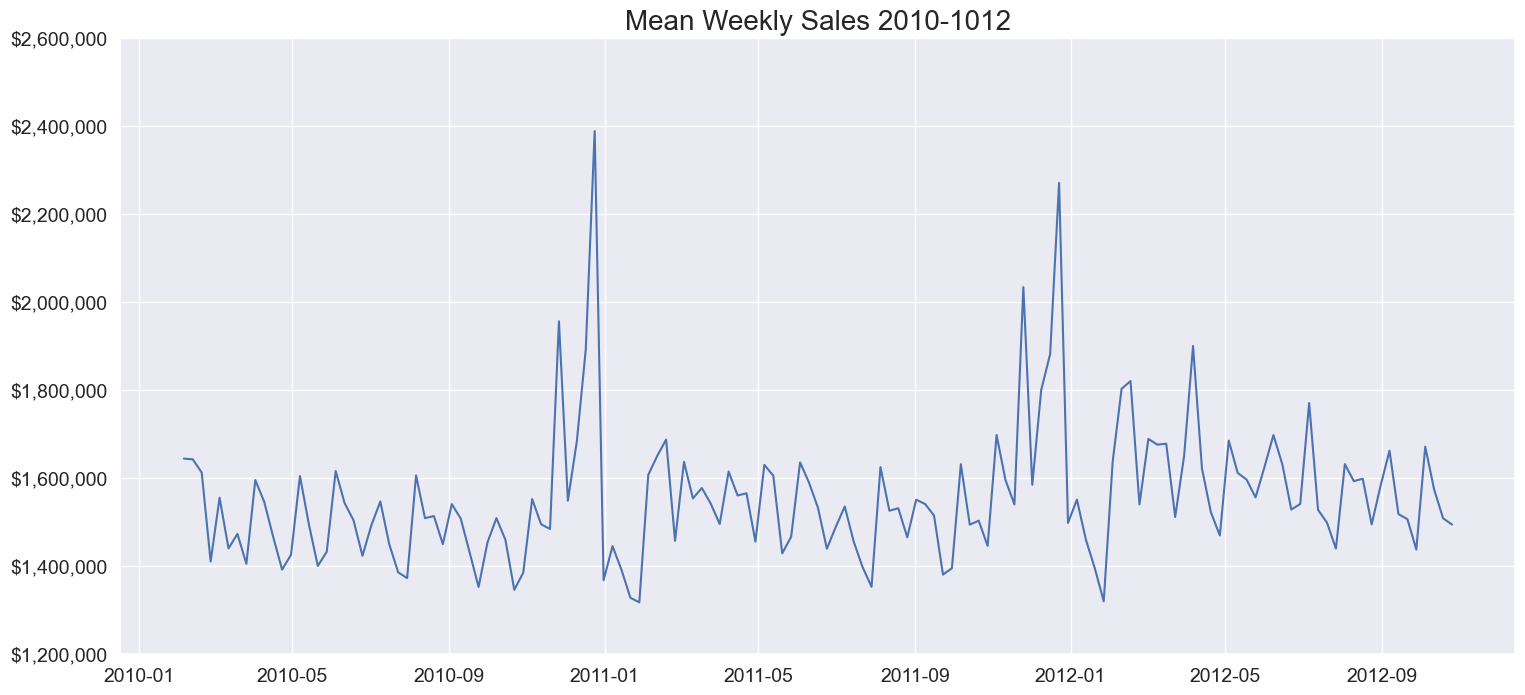

In [6]:
plt.figure(figsize=(18, 8))
g = sns.lineplot(data=df, x=df.index, y="Weekly_Sales", errorbar=None)

g.set_title("Mean Weekly Sales 2010-1012", fontsize=20)
g.set(xlabel="", ylabel="")

yticks = g.get_yticks()
g.set_yticks(ticks = yticks, labels = [f"${int(i):,}" for i in yticks])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show();

It seems there is a strong pattern, specially at the end of the year.

In [7]:
month_sales = df.groupby([df.index.year, df.index.month]).agg({"Weekly_Sales": "sum", "Holiday_Flag": "sum", "Temperature": "mean", "Fuel_Price": "mean", "CPI": "mean", "Unemployment": "mean"})
month_sales.columns = ["Sales", "Holidays", "Temperature", "Fuel_Price", "CPI", "Uneployment"]
month_sales.index = pd.to_datetime([f"{year}-{month}-01" for year, month in month_sales.index])
month_sales.index = month_sales.index.rename("Date")

month_sales.head(3)

,Sales,Holidays,Temperature,Fuel_Price,CPI,Uneployment
Date,,,,,,
2010-02-01,6307344.10,1,41.84,2.55,211.24,8.11
2010-03-01,5871293.98,0,52.58,2.69,211.24,8.11
2010-04-01,7422801.92,0,65.34,2.77,210.55,7.81


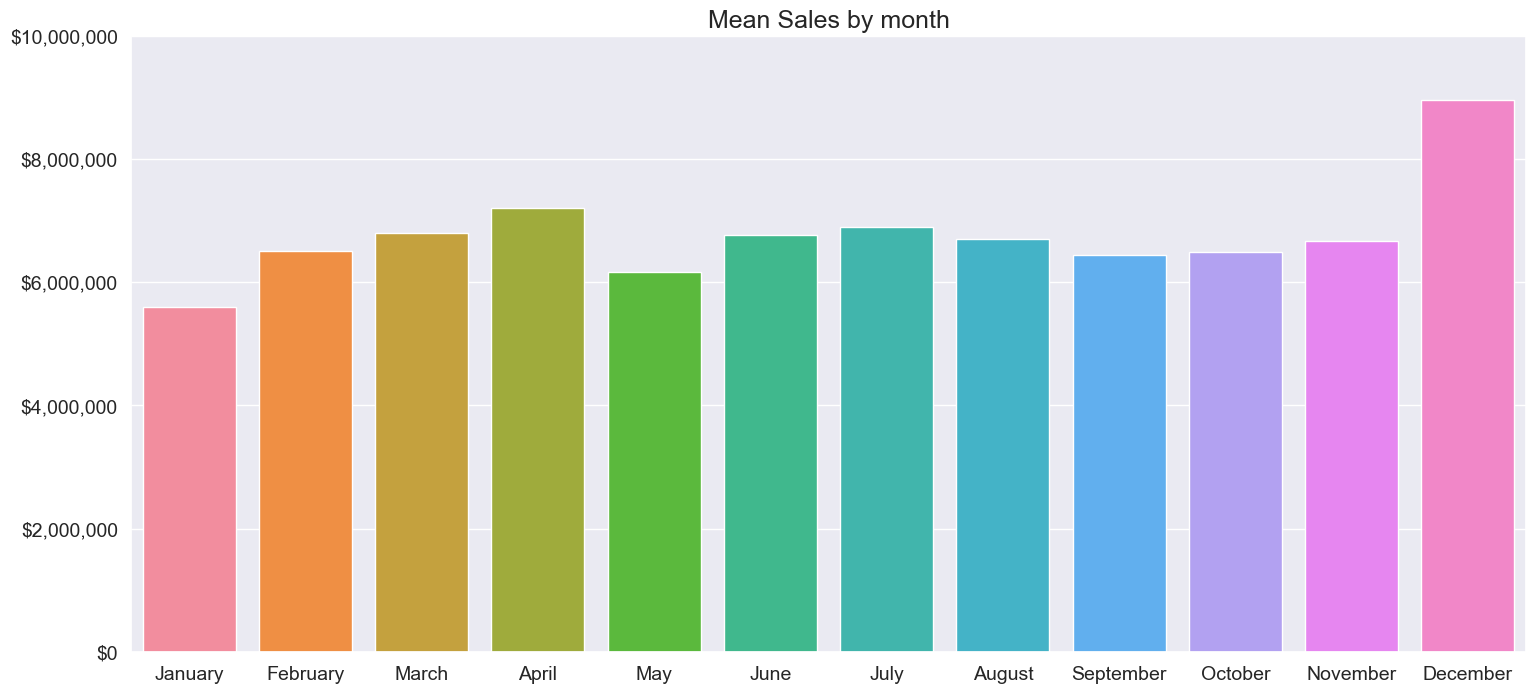

In [8]:
plt.figure(figsize=(18, 8))
g = sns.barplot(x=month_sales.index.month, y="Sales", data=month_sales, estimator=np.mean, errorbar=None, saturation=0.9);

g.set_title("Mean Sales by month", size=18)
g.set(xlabel="", ylabel="")

yticks = g.get_yticks()
g.set_yticks(ticks = yticks, labels = [f"${int(i):,}" for i in yticks], fontsize=14);

month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
g.set_xticks(ticks = g.get_xticks(), labels = month_names, fontsize=14)

plt.show();

It is clear that there is a peak in sales during December, driven by increased consumer spending during the holiday season. This is followed by a decline in January as consumers recover from holiday bills. On the other hand, sales during April and July are also considerably high.

### Feature Engineering

In [9]:
def add_time_features(df):
    df["Day"] = df.index.day
    df["Part_of_month"] = np.ceil(df.index.day / (df.index.days_in_month / 4))    
    df["Month"] = df.index.month
    df["Quarter"] = df.index.quarter
    df["Year"] = df.index.year
    df["Week_of_year"] = df.index.isocalendar().week
    #df["Day_of_week"] = df.index.dayofweek
    #df["Day_of_month"] = df.index.day
    #df["Day_of_year"] = df.index.dayofyear
    # The commented features are not relevant or provide the same information than the other ones.

In [10]:
mean_temperature = np.mean(df.Temperature)
df["Temperature_Difference"] = abs(df.Temperature - mean_temperature)  # I consider that probably the more you move away from average temperature the less sales

add_time_features(df)

df.head(3)

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Temperature_Difference,Day,Part_of_month,Month,Quarter,Year,Week_of_year
Date,,,,,,,,,,,,,
2010-02-05,1643690.90,0,42.31,2.57,211.10,8.11,26.00,5,1.00,2,1,2010,5
2010-02-12,1641957.44,1,38.51,2.55,211.24,8.11,29.80,12,2.00,2,1,2010,6
2010-02-19,1611968.17,0,39.93,2.51,211.29,8.11,28.38,19,3.00,2,1,2010,7


#### Dividing the data into train and test sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Weekly_Sales", axis=1), df["Weekly_Sales"], test_size=0.2, random_state=1)

#### Feature Scaling

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Machine Learning Models

In [13]:
def evaluate_model(y_true, y_pred, ind=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        "MSE": [f"{mse:,.2f}"],
        "RMSE": [f"{rmse:,.2f}"],
        "MAE": [f"{mae:,.2f}"],
        "MAPE": [f"{100 * mape:,.2f}"],
        "R2": [f"{r2:,.2f}"]
    }
    
    return pd.DataFrame(metrics, index=[ind])

##### Baseline Model with Mean Weekly Sales

In [14]:
mean_sales = np.mean(df["Weekly_Sales"])
y_mean = pd.Series(np.full_like(df["Weekly_Sales"], mean_sales))
evaluate_model(df["Weekly_Sales"], y_mean)

,MSE,RMSE,MAE,MAPE,R2
,"24,159,860,051.85","155,434.42","105,704.61",6.58,0.00


##### Random Forest Regressor

In [15]:
model = RandomForestRegressor(random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
evaluate_model(y_test, y_predicted)

,MSE,RMSE,MAE,MAPE,R2
,"16,059,689,343.12","126,726.83","82,960.99",4.93,0.53


##### XGB Regressor

In [16]:
xgb_model = xgb.XGBRegressor(base_score=0.5,
                       n_estimators=1000,
                       learning_rate=0.01,
                       early_stopping_rounds=50)

xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False);

In [17]:
y_test_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_test_pred, "Test Results")

,MSE,RMSE,MAE,MAPE,R2
Test Results,"8,039,150,202.27","89,661.31","62,041.93",3.70,0.76


In [18]:
y_train_pred = model.predict(X_train)
evaluate_model(y_train, y_train_pred, "Train Results")

,MSE,RMSE,MAE,MAPE,R2
Train Results,"3,000,619,289.58","54,777.91","27,871.54",1.73,0.86


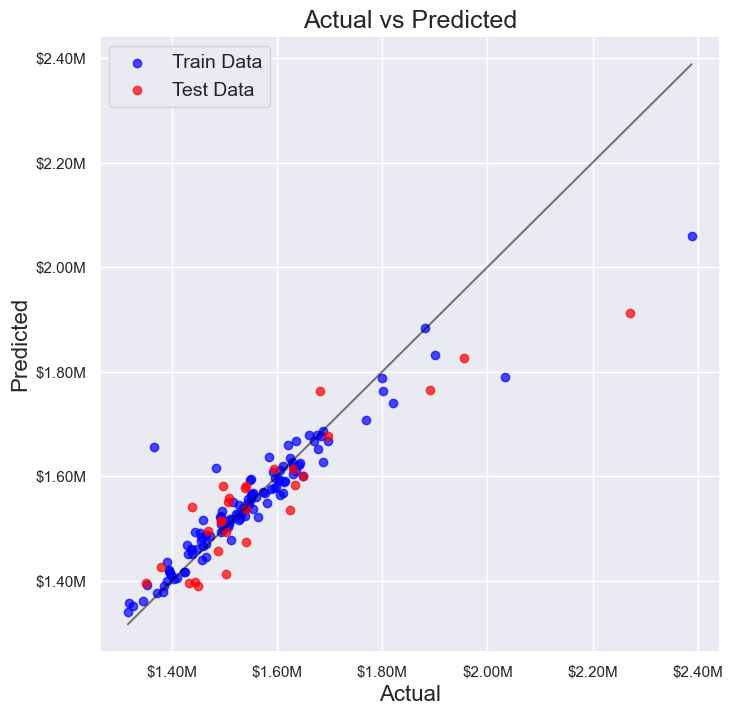

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred, color="blue", alpha=0.7, label="Train Data")
plt.scatter(y_test, y_test_pred, color="red", alpha=0.7, label="Test Data")

min_value = min(df["Weekly_Sales"])
max_value = max(df["Weekly_Sales"])
plt.plot([min_value, max_value], [min_value, max_value], color="black", alpha=0.5)

xticks = plt.xticks()[0][1:-1]
x_tick_labels = [f"${tick/1e6:.2f}M" for tick in xticks]
plt.xticks(xticks, x_tick_labels)

yticks = plt.yticks()[0][1:-1]
y_tick_labels = [f"${tick/1e6:.2f}M" for tick in yticks]
plt.yticks(xticks, y_tick_labels)

plt.title("Actual vs Predicted", fontsize=18)
plt.legend(fontsize=14)
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)

plt.show()

Although there are some outliers, the predicted values closely match the actual values, indicating that the model performs well.

#### Weekly Sales Forecast

In [20]:
dates = pd.date_range(start="2012-10-26", end="2013-10-27", freq="W")
predictions_df = pd.DataFrame(index=dates)
add_time_features(predictions_df)

In [21]:
df.columns

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Temperature_Difference', 'Day', 'Part_of_month',
       'Month', 'Quarter', 'Year', 'Week_of_year'],
      dtype='object')

In [22]:
time_features = ["Day", "Part_of_month", "Month", "Quarter", "Year", "Week_of_year"]

for feature in ["Temperature", "Fuel_Price", "CPI", "Unemployment"]:
    model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
    model.fit(df[time_features], df[feature])
    predictions_df[feature] = model.predict(predictions_df[time_features])

In [23]:
predictions_df["Holiday_Flag"] = df.loc[df.index > pd.to_datetime("2011-10-26"), "Holiday_Flag"].values

mean_temperature = np.mean(predictions_df.Temperature)
predictions_df["Temperature_Difference"] = abs(predictions_df.Temperature - mean_temperature)

df.tail(2)

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Temperature_Difference,Day,Part_of_month,Month,Quarter,Year,Week_of_year
Date,,,,,,,,,,,,,
2012-10-19,1508068.77,0,67.97,3.59,223.43,6.57,0.34,19,3.00,10,4,2012,42
2012-10-26,1493659.74,0,69.16,3.51,223.44,6.57,0.85,26,4.00,10,4,2012,43


In [24]:
predictions_df.head(2)

,Day,Part_of_month,Month,Quarter,Year,Week_of_year,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag,Temperature_Difference
2012-10-28,28,4.00,10,4,2012,43,68.04,3.50,223.40,6.58,0,1.09
2012-11-04,4,1.00,11,4,2012,44,56.78,3.42,223.31,6.58,0,10.16


In [25]:
df.describe()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Temperature_Difference,Day,Part_of_month,Month,Quarter,Year,Week_of_year
count,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00,143.00
mean,1555264.40,0.07,68.31,3.22,216.00,7.61,11.96,15.68,2.54,6.45,2.48,2010.97,25.82
std,155980.77,0.26,14.25,0.43,4.35,0.38,7.68,8.79,1.11,3.25,1.07,0.80,14.18
min,1316899.31,0.00,35.40,2.51,210.34,6.57,0.24,1.00,1.00,1.00,1.00,2010.00,1.00
25%,1458104.69,0.00,58.27,2.76,211.55,7.35,5.43,8.00,2.00,4.00,2.00,2010.00,14.00
50%,1534849.64,0.00,69.64,3.29,215.46,7.79,12.11,16.00,3.00,6.00,2.00,2011.00,26.00
75%,1614892.03,0.00,80.48,3.59,220.53,7.84,17.49,23.00,4.00,9.00,3.00,2012.00,37.50
max,2387950.20,1.00,91.65,3.91,223.44,8.11,32.91,31.00,4.00,12.00,4.00,2012.00,52.00


In [26]:
predictions_df.describe()

,Day,Part_of_month,Month,Quarter,Year,Week_of_year,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag,Temperature_Difference
count,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00
mean,16.08,2.58,6.64,2.53,2012.81,26.81,66.95,3.51,221.97,6.99,0.08,10.38
std,8.92,1.13,3.49,1.14,0.39,15.18,12.24,0.19,1.09,0.29,0.27,6.33
min,1.00,1.00,1.00,1.00,2012.00,1.00,45.47,3.21,219.82,6.58,0.00,0.04
25%,9.00,2.00,4.00,2.00,2013.00,14.00,57.52,3.35,221.45,6.61,0.00,5.76
50%,16.00,3.00,7.00,3.00,2013.00,27.00,68.15,3.50,221.89,6.93,0.00,11.80
75%,24.00,4.00,10.00,4.00,2013.00,40.00,78.82,3.64,223.19,7.16,0.00,15.81
max,31.00,4.00,12.00,4.00,2013.00,52.00,85.29,3.86,223.40,7.35,1.00,21.48


The artificially generated predictions data looks decent compared to the main df.

In [27]:
predictions_df = predictions_df[["Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Temperature_Difference", "Day", "Part_of_month", "Month", "Quarter", "Year", "Week_of_year"]]
y_future_predicted = xgb_model.predict(scaler.transform(predictions_df))

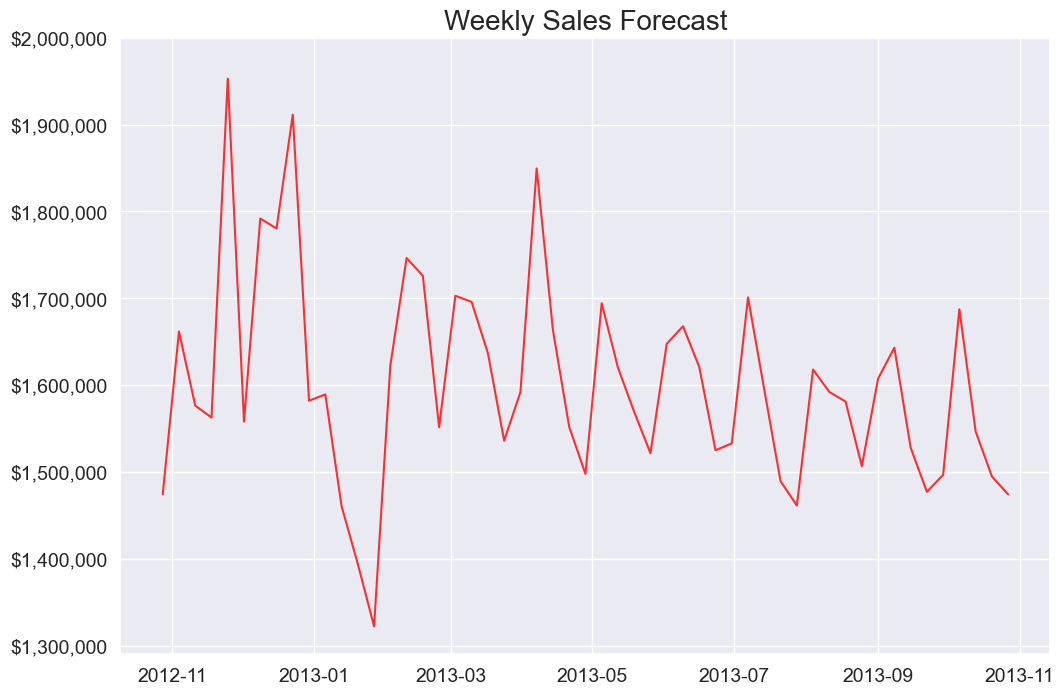

In [28]:
plt.figure(figsize=(12, 8))

g = sns.lineplot(x=predictions_df.index, y=y_future_predicted, color="red", alpha=0.8)

yticks = g.get_yticks()[1:]
g.set_yticks(ticks=yticks, labels=[f"${int(i):,}" for i in yticks])

g.set_title("Weekly Sales Forecast", fontsize=20)
g.set(xlabel="", ylabel="")

plt.yticks(fontsize=14) 
plt.xticks(fontsize=14)

plt.show();

As expected, the forecast captures the patterns of the original dataset. Is is important to mention that this was based on the predictions of the features: temperature, fuel price, CPI, unemployment. This considerably reduces the accuracy of the forecast. It would be a good idea to simulate data variations (e.g.: an increase in fuel price or unenployemnt would decreese sales)  and generate multiple visualizations to be aware of the different possible scenarios.